In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
!pip install matplotlib
from matplotlib.dates import MonthLocator

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from pathlib import Path
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, distinct
# Create a reference to the file. 
database_path = Path("../Resources/hawaii.sqlite")

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# Reflect the database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# Access the reflected tables
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session
session = Session(engine)

# Query All Records in the Measurement table
measurement_records = session.query(Measurement).limit(5).all()
for record in measurement_records:
    print(record.__dict__)

# Query All Records in the Station table
station_records = session.query(Station).limit(5).all()
for record in station_records:
    print(record.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002901A421540>, 'prcp': 0.08, 'id': 1, 'date': '2010-01-01', 'tobs': 65.0, 'station': 'USC00519397'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002901A4214E0>, 'prcp': 0.0, 'id': 2, 'date': '2010-01-02', 'tobs': 63.0, 'station': 'USC00519397'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002901A4214B0>, 'prcp': 0.0, 'id': 3, 'date': '2010-01-03', 'tobs': 74.0, 'station': 'USC00519397'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002901A4215D0>, 'prcp': 0.0, 'id': 4, 'date': '2010-01-04', 'tobs': 76.0, 'station': 'USC00519397'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002901A421630>, 'prcp': None, 'id': 5, 'date': '2010-01-06', 'tobs': 73.0, 'station': 'USC00519397'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002901A422E30>, 'longitude': -157.8168, 'station': 'US

In [6]:
# View the columns for the 'station' table
station_columns = Station.__table__.columns.keys()
print("Columns for the 'station' table:", station_columns)

# View the columns for the 'measurement' table
measurement_columns = Measurement.__table__.columns.keys()
print("Columns for the 'measurement' table:", measurement_columns)

Columns for the 'station' table: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']
Columns for the 'measurement' table: ['id', 'station', 'date', 'prcp', 'tobs']


In [7]:
# Save references to each table


In [8]:
# Create our session (link) from Python to the DB


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


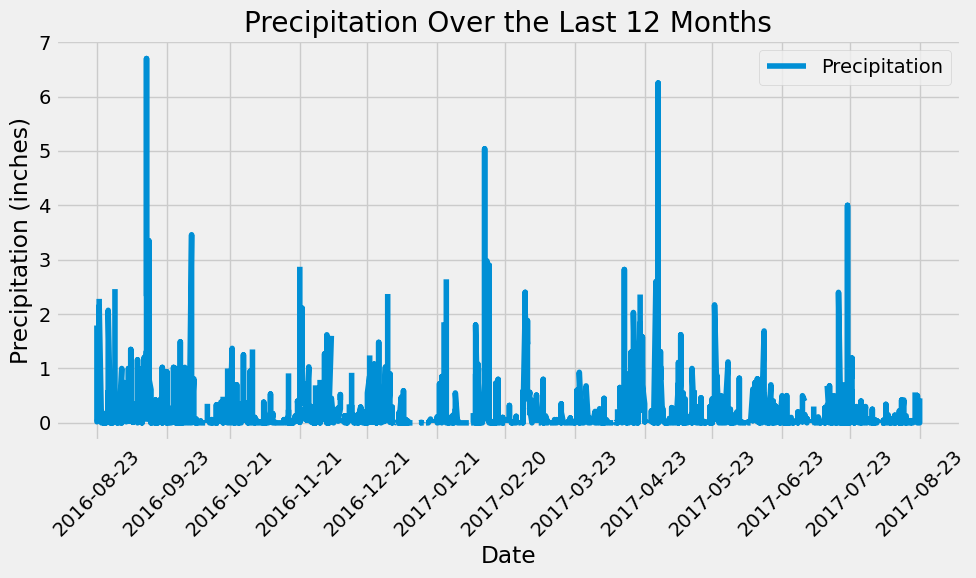

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import func

# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Plot the results using the DataFrame plot method
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.legend()

# Set the x-axis locator to show only one label per month
plt.gca().xaxis.set_major_locator(MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Print the summary statistics
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(Station.station))).scalar()

# Print the result
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('lowest_temperature'),
    func.max(Measurement.tobs).label('highest_temperature'),
    func.avg(Measurement.tobs).label('average_temperature')
).filter(Measurement.station == most_active_station_id).all()

# Print the results
for result in temperature_stats:
    print(f"Station ID: {most_active_station_id}")
    print(f"Lowest Temperature: {result.lowest_temperature} °F")
    print(f"Highest Temperature: {result.highest_temperature} °F")
    print(f"Average Temperature: {result.average_temperature} °F")

Station ID: USC00519281
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


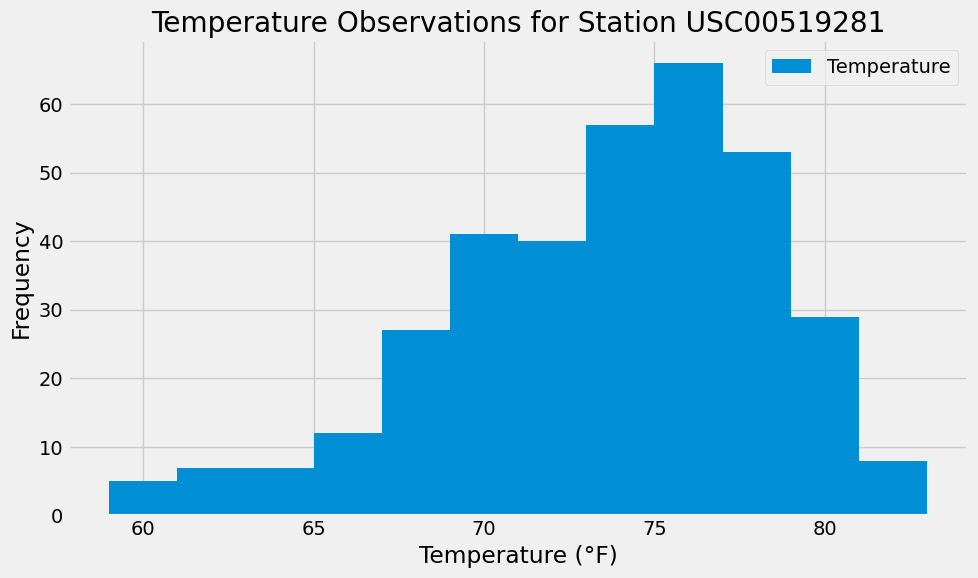

In [15]:
# Using the most active station id
most_active_station_id = 'USC00519281'

# Convert one_year_ago to a string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
temperature_df.plot.hist(bins=12, figsize=(10, 6), title=f'Temperature Observations for Station {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()